# Change in exposure to heatwaves

## Original method

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

## Proposed new method

Heat waves are defined as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

## Trends and exposure risk

To calculate the exposure of people to heatwave, we consider only the population over 65. This older population is more vulnerable to health impacts from heatwaves.

General trends are calculated by comparing the global trend in number of heatwave days (mean days per year in heatwave conditions) and the population-weighted trend in heatwave days.

 
The heatwave risk H is measured as the change in heatwave frequency ∆H multiplied by the population:

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.

This produces a 'heatwave exposure' indicator measured in heatwave-persons.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC


In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [15]:
MAX_YEAR = 2019

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020'

POPULATION_FILE = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'

DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographics_fraction_1950_2050.nc'
DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_1950_2020.nc'

In [4]:
MAP_PROJECTION = ccrs.EckertIII()

## Load country data

In [5]:
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [6]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [7]:
land_mask  = (COUNTRIES_RASTER.country_codes < 1000)

## Load population and demographic data

In [8]:
# demographics = xr.open_dataarray(DEMOGRAPHICS_FILE)
# fraction_over_65 = demographics.sel(age_band_lower_bound=65, drop=True).load()
# population = xr.open_dataarray(POPULATION_FILE)
# population_over_65 = population * fraction_over_65

In [9]:
demographics_totals = xr.open_dataarray(DEMOGRAPHICS_TOTALS_FILE)
population_over_65 = demographics_totals.sel(age_band_lower_bound=65, drop=True).load()

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [10]:
heatwave_metrics_files = [f'heatwaves_counts_1980-{MAX_YEAR}.nc', 
                          f'heatwaves_days_1980-{MAX_YEAR}.nc', 
                          f'heatwaves_deg_days_1980-{MAX_YEAR}.nc', 
                          f'heatwave_mean_length_1980-{MAX_YEAR}.nc', 
                          f'heatwave_degrees_1980-{MAX_YEAR}.nc']

heatwave_metrics_files = [
    INTERMEDIATE_RESULTS_FOLDER / f 
    for f in heatwave_metrics_files
]
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')

In [9]:
heatwave_metrics

<xarray.Dataset>
Dimensions:               (latitude: 361, longitude: 720, year: 40)
Coordinates:
  * longitude             (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * latitude              (latitude) float64 90.0 89.5 89.0 ... -89.5 -90.0
  * year                  (year) int64 1980 1981 1982 1983 ... 2017 2018 2019
Data variables:
    heatwave_degrees      (year, latitude, longitude) float32 dask.array<chunksize=(40, 361, 720), meta=np.ndarray>
    heatwave_mean_length  (year, latitude, longitude) float32 dask.array<chunksize=(40, 361, 720), meta=np.ndarray>
    heatwaves_counts      (year, latitude, longitude) int16 dask.array<chunksize=(40, 361, 720), meta=np.ndarray>
    heatwaves_days        (year, latitude, longitude) int16 dask.array<chunksize=(40, 361, 720), meta=np.ndarray>
    heatwaves_deg_days    (year, latitude, longitude) float32 dask.array<chunksize=(40, 361, 720), meta=np.ndarray>

### Calculate the difference from the mean number of days and number of events

> NOTE: we do a sort of double-difference in this case, since we first define heatwaves based on a historical distribution (99th percentile) then we again calculate the change. Question is open as to whether it's also critical to use the same period for calculating the percentile and calculating the reference period. Also a question whether we should compare the change in exposures rather than the change in heatwaves. The problem (or maybe it's a benefit??) is that you also mix in changes in total population and demographics


In [11]:
heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference

## Calculate some utility data

In [12]:
# Get the grid weighting factor from the latitude
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwave_metrics.latitude))
# Get the total population for normalising
total_pop_over_65 = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

## Map plots of heatwaves

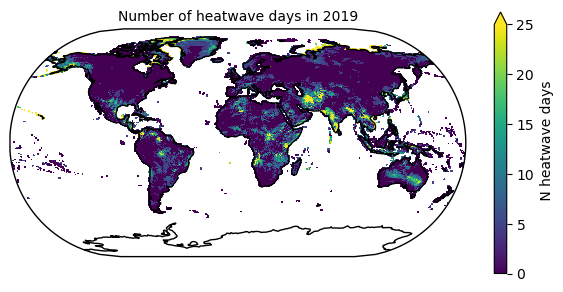

In [51]:
data = heatwave_metrics.where(land_mask).heatwaves_days.sel(year=MAX_YEAR)

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

p = data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
                 'label':' N heatwave days'},
    robust=True
)

ax.set(title='Number of heatwave days in 2019')

ax.coastlines()
plt.tight_layout()

f.savefig(RESULTS_FOLDER / f'map_heatwave_days_{MAX_YEAR}.png')

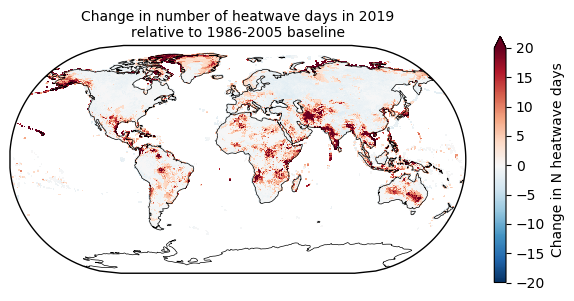

In [52]:
data = heatwave_metrics_delta.where(land_mask).heatwaves_days.sel(year=MAX_YEAR)

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

p = data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
                 'label':'Change in N heatwave days'},
    center=0,
vmax=20,  cmap='RdBu_r', 
)
ax.set(title='Change in number of heatwave days in 2019\nrelative to 1986-2005 baseline')

ax.coastlines(linewidth=0.5)
plt.tight_layout()

f.savefig(RESULTS_FOLDER / f'map_change_heatwave_days_{MAX_YEAR}.png')

# Calculate total exposures and save for all metrics

Because the calculation is the same for all metrics, we can calculated it once on the dataset and save

In [15]:
exposures = heatwave_metrics_delta * population_over_65

In [16]:
exposures.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_1980-{MAX_YEAR}.nc')

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [13]:
exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_1980-{MAX_YEAR}.nc')

# Calculate global mean and exposure weighted values for all metrics

In [17]:
global_mean = (heatwave_metrics_delta * cos_lat).mean(dim=['latitude', 'longitude'])
weighted_mean = (heatwave_metrics_delta * population_over_65 / total_pop_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [18]:
global_mean = global_mean.to_dataframe()
weighted_mean = weighted_mean.to_dataframe()

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathancha

In [45]:
global_mean.to_excel(RESULTS_FOLDER / 'metrics_global_mean.xlsx')
weighted_mean.to_excel(RESULTS_FOLDER / 'metrics_weighted_mean.xlsx')

# Plot Global mean and exposure weighted means for heatwave metrics

## TODO would be good to also compare values over land only

In [6]:
global_mean = pd.read_excel(RESULTS_FOLDER / 'metrics_global_mean.xlsx').set_index('year')
weighted_mean = pd.read_excel(RESULTS_FOLDER / 'metrics_weighted_mean.xlsx').set_index('year')

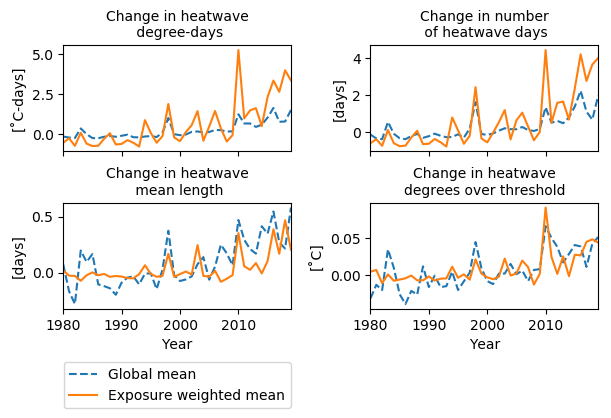

In [21]:
f, axs = plt.subplots(2,2, sharex=True, 
                      figsize=(6,4),
                      constrained_layout=True
                     )

metrics  = ['heatwaves_deg_days', 'heatwaves_days','heatwave_mean_length','heatwave_degrees',]
y_labels = ['[˚C-days]', '[days]', '[days]', '[˚C]']
titles   = ['Change in heatwave\n degree-days', 'Change in number\n of heatwave days',
          'Change in heatwave\n mean length', 'Change in heatwave\ndegrees over threshold']

for metric, ylab, title, ax in zip(metrics, y_labels, titles, axs.flat):
    global_mean[metric].plot(style='--', color='C0',label='Global mean', ax=ax)
    weighted_mean[metric].plot(color='C1',label='Exposure weighted mean', ax=ax)
    ax.set(
        xlabel='Year',
        ylabel=ylab,
        title=title
    )

axs[1,0].legend(loc='lower center', bbox_to_anchor=(0.5, -1))

f.savefig(RESULTS_FOLDER / f'heatwaves_metrics_weighted_1980-{MAX_YEAR}.png', bbox_inches='tight')


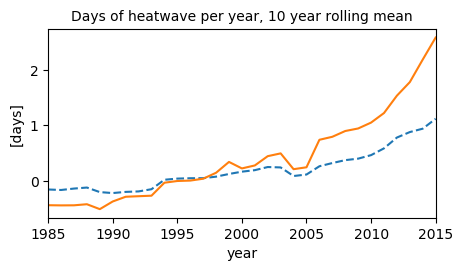

In [13]:
(global_mean.rolling(10, center=True).mean().dropna()).heatwaves_days.plot(style='--', label='Global mean')
ax = (weighted_mean.rolling(10, center=True).mean().dropna()).heatwaves_days.plot(label='Population weighted mean')
ax.set(ylabel='[days]',
       title='Days of heatwave per year, 10 year rolling mean'
      )
ax.figure.savefig(RESULTS_FOLDER / f'heatwaves_days_10yr_1985-{MAX_YEAR-5}.png', bbox_inches='tight')


In [36]:
# global_mean.heatwaves_days.plot(color='C1',label='Global mean')
# weighted_mean.heatwaves_days.plot(color='C0',label='Exposure weighted mean')

# plt.xlabel('Year')
# plt.ylabel('Change in yearly number\n of heatwave days')
# plt.legend()
# plt.savefig(RESULTS_FOLDER / f'heatwaves_days_weighted_1980-{MAX_YEAR}.png', bbox_inches='tight')

In [37]:
# global_mean_heatwave_deg_days.plot(color='C1',label='Global mean')
# weighted_mean_heatwave_deg_days.plot(color='C0',label='Exposure weighted mean')

# plt.xlabel('Year')
# plt.ylabel('Change in yearly \n heatwave degree-days')
# plt.legend()
# plt.savefig(RESULTS_FOLDER / f'heatwaves_deg_days_weighted_1980-{MAX_YEAR}.png',bbox_inches='tight')

In [38]:
# global_mean_heatwave_mean_length.plot(color='C1',label='Global mean')
# weighted_mean_heatwave_mean_length.plot(color='C0',label='Exposure weighted mean')

# plt.xlabel('Year')
# plt.ylabel('Change in yearly \n heatwave mean length (days)')
# plt.legend()
# plt.savefig(RESULTS_FOLDER / f'heatwaves_mean_length_weighted_1980-{MAX_YEAR}.png',bbox_inches='tight')

In [39]:
# global_mean_heatwave_degrees.plot(color='C1',label='Global mean')
# weighted_mean_heatwave_degrees.plot(color='C0',label='Exposure weighted mean')

# plt.xlabel('Year')
# plt.ylabel('Change in heatwave\ndegrees over threshold (˚C)')
# plt.legend()
# plt.savefig(RESULTS_FOLDER / f'heatwaves_degrees_weighted_1980-{MAX_YEAR}.png', bbox_inches='tight')

# Total Exposure to change in  to heatwaves

Calculate exposure changes in terms of difference aspects of heatwaves - frequency, length, load. 

> **NOTE**: Keep the of number of individual events (rather than number of days) for historical reasons, but no longer focus on that because number of heatwave days is just generally a better measure than individual instances.


In [42]:
total_exposures = exposures.sum(dim=['latitude', 'longitude']).to_dataframe()

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [44]:
total_exposures.to_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals.xlsx')

In [58]:
(total_exposures.rolling(10, center=True).mean().dropna()).to_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_10yr_mean.xlsx')

## Reload saved numbers

In [16]:
total_exposures = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals.xlsx', index_col='year')

## Count of separate heatwave events (depreciated)

Calculate the change in number of people exposed to heatwaves over time. One exposure event = 1 person * 1 heatwave

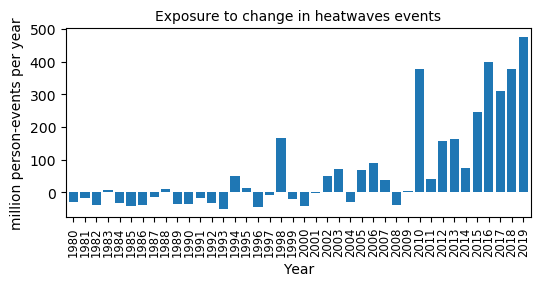

In [21]:
ax = (total_exposures.heatwaves_counts / 1e6).plot.bar(label='Change relative to recent past average', width=0.8)
f = ax.figure
f.set_size_inches((6, 2.5))

ax.set(
    xlabel='Year',
    ylabel='million person-events per year',
    title='Exposure to change in heatwaves events'
)

ax.tick_params(axis='x', labelsize='small')

f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_1980-{MAX_YEAR}.pdf')


## Exposure to change in number of days (HWMI analogue)

This supercedes the number of exposure events, and is closer to the HWMI method of calculating heatwaves

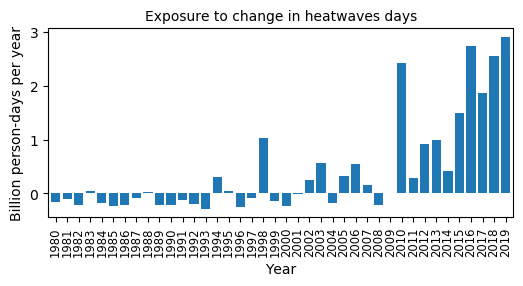

In [22]:
ax = (total_exposures.heatwaves_days / 1e9).plot.bar(label='Change relative to recent past average', width=0.8)
f = ax.figure
f.set_size_inches((6, 2.5))

ax.set(
    xlabel='Year',
    ylabel='Billion person-days per year',
    title='Exposure to change in heatwaves days'
)

ax.xaxis.set_tick_params(labelsize='small')

f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_days_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_days_1980-{MAX_YEAR}.pdf')


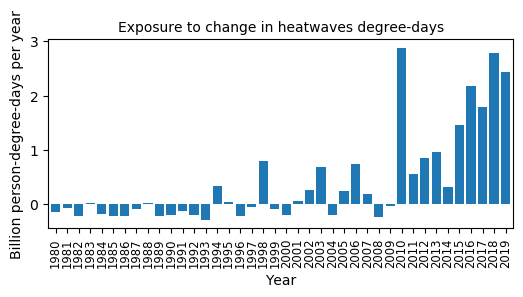

In [23]:
ax = (total_exposures.heatwaves_deg_days / 1e9).plot.bar(label='Change relative to recent past average', width=0.8)
f = ax.figure
f.set_size_inches((6, 2.5))

ax.set(
    xlabel='Year',
    ylabel='Billion person-degree-days per year',
    title='Exposure to change in heatwaves degree-days'
)

ax.tick_params(axis='x', labelsize='small')

f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_deg_days_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_deg_days_1980-{MAX_YEAR}.pdf')


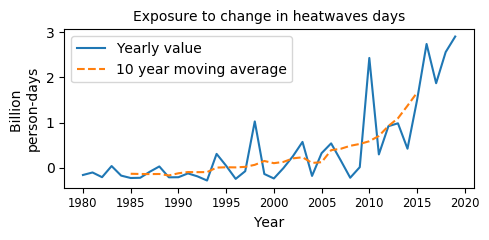

In [24]:
f, ax = plt.subplots(1,1, sharex=True)

(total_exposures.heatwaves_days / 1e9).plot(style='-',label='Yearly value',  ax=ax)
(total_exposures.heatwaves_days.rolling(10, center=True).mean().dropna() / 1e9).plot(ax=ax,style='--',label='10 year moving average')

ax.set(
    xlabel='Year',
    ylabel='Billion \nperson-days',
    title='Exposure to change in heatwaves days'
)

ax.xaxis.set_tick_params(labelsize='small')

ax.legend()

f.tight_layout()

f.savefig(RESULTS_FOLDER / f'hw_exposure_rolling_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_rolling_1980-{MAX_YEAR}.pdf')

## Calculate the average exposure

In [20]:
heatwaves_metrics_reference

<xarray.Dataset>
Dimensions:               (latitude: 361, longitude: 720)
Coordinates:
  * longitude             (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * latitude              (latitude) float64 90.0 89.5 89.0 ... -89.5 -90.0
Data variables:
    heatwave_degrees      (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwave_mean_length  (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_counts      (latitude, longitude) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_days        (latitude, longitude) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_deg_days    (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>

In [21]:
(heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)) * population_over_65).mean(dim='year')

<xarray.Dataset>
Dimensions:               (latitude: 290, longitude: 720)
Coordinates:
  * latitude              (latitude) float64 85.0 84.5 84.0 ... -59.0 -59.5
  * longitude             (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    heatwave_degrees      (latitude, longitude) float64 dask.array<chunksize=(290, 720), meta=np.ndarray>
    heatwave_mean_length  (latitude, longitude) float64 dask.array<chunksize=(290, 720), meta=np.ndarray>
    heatwaves_counts      (latitude, longitude) float64 dask.array<chunksize=(290, 720), meta=np.ndarray>
    heatwaves_days        (latitude, longitude) float64 dask.array<chunksize=(290, 720), meta=np.ndarray>
    heatwaves_deg_days    (latitude, longitude) float64 dask.array<chunksize=(290, 720), meta=np.ndarray>

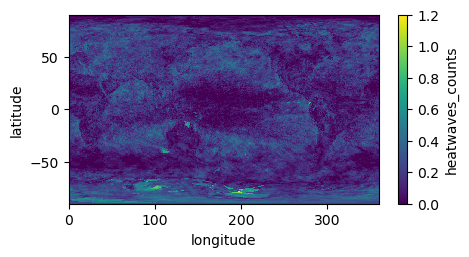

In [24]:
heatwaves_metrics_reference.heatwaves_counts.plot()

In [33]:
heatwaves_metrics_reference

<xarray.Dataset>
Dimensions:               (latitude: 361, longitude: 720)
Coordinates:
  * longitude             (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * latitude              (latitude) float64 90.0 89.5 89.0 ... -89.5 -90.0
Data variables:
    heatwave_degrees      (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwave_mean_length  (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_counts      (latitude, longitude) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_days        (latitude, longitude) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    heatwaves_deg_days    (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>

In [37]:
# Use the population count in 2000 as an approximation for the historical population
# year = 2000
heatwave_events_historical = (heatwave_metrics * 
                              population_over_65
                             ).sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')

heatwave_events_historical = heatwave_events_historical.sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [38]:
heatwave_events_historical.heatwaves_counts / 1e6

<xarray.DataArray 'heatwaves_counts' ()>
array(118.68952581)

In [36]:
# # Use the population count in 2000 as an approximation for the historical population
# year = 2000
# heatwave_events_historical = heatwaves_metrics_reference * population_over_65.sel(year=year, drop=True) 
# heatwave_events_historical = heatwave_events_historical.sum(dim=['latitude', 'longitude']).compute()
# heatwave_events_historical.heatwaves_counts / 1e6

In [31]:
# FOR THE LANCET, JUST INCLUDE THE DAYS EXPOSURE (forget about degree-days)
# f, axs = plt.subplots(2,1, sharex=True, figsize=(6, 3.5))

# ax = axs[0]
# (total_exposure_deg_days.exposures / 1e9).plot(style='--',label='Yearly value',  ax=ax)
# (total_exposure_deg_days.exposures.rolling(10, center=True).mean().dropna() / 1e9).plot(ax=ax,label='10 year moving average')

# ax.set(
#     xlabel='Year',
#     ylabel='Billion \nperson-˚C-days',
#     title='Exposure to change in heatwaves degree-days'
# )

# ax.xaxis.set_tick_params(labelsize='small')
# ax.legend()

# ax = axs[1]

# (total_exposure_days.exposures / 1e9).plot(style='--',label='Yearly value',  ax=ax)
# (total_exposure_days.exposures.rolling(10, center=True).mean().dropna() / 1e9).plot(ax=ax,label='10 year moving average')

# ax.set(
#     xlabel='Year',
#     ylabel='Billion \nperson-days',
#     title='Exposure to change in heatwaves days'
# )

# ax.xaxis.set_tick_params(labelsize='small')

# ax.legend()

# f.tight_layout()

# plt.savefig(RESULTS_FOLDER / f'hw_exposure_rolling_1980-{MAX_YEAR}.png', bbox_inches='tight')

In [32]:
# f, ax= plt.subplots()
# f.set_size_inches((6, 2.5))

# (total_exposure_deg_days.exposures / 1e9).plot(style='--',label='Yearly value',  ax=ax)
# (total_exposure_deg_days.exposures.rolling(10, center=False).mean().dropna() / 1e9).plot(ax=ax,label='10 year rolling mean')

# ax.set(
#     xlabel='Year',
#     ylabel='Billion person-degree-days',
#     title='Exposure to change in heatwaves degree-days'
# )

# ax.xaxis.set_tick_params(labelsize='small')

# ax.legend()

# plt.savefig(RESULTS_FOLDER / f'hw_degday_exposure_rolling_1980-{MAX_YEAR}.png', bbox_inches='tight')

In [80]:
# f, ax= plt.subplots()
# f.set_size_inches((6, 2.5))

# (total_exposure_days.exposures / 1e9).plot(style='--',label='Yearly value',  ax=ax)
# (total_exposure_days.exposures.rolling(10, center=False).mean().dropna() / 1e9).plot(ax=ax,label='10 year rolling mean')

# ax.set(
#     xlabel='Year',
#     ylabel='Billion person-days',
#     title='Exposure to change in heatwaves days'
# )

# ax.xaxis.set_tick_params(labelsize='small')

# ax.legend()

# plt.savefig(RESULTS_FOLDER / f'hw_exposure_rolling_1980-{MAX_YEAR}.png', bbox_inches='tight')